In [54]:

import json
import pandas as pd


def load_df(csv_path='/kaggle/input/ga-customer-revenue-prediction/train_v2.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    df.drop(columns=['customDimensions', 'hits'], inplace=True)

    df = df.fillna({'totals_pageviews':0,
                    'totals_transactionRevenue':0,
                    'totals_pageviews':0})

    df['device_isMobile'] = df['device_isMobile'].astype(int)
    df['totals_transactionRevenue'] = df['totals_transactionRevenue'].astype(int)

    cat_col = df.select_dtypes(include='object').columns

    df[cat_col] = df[cat_col].astype(str)

    return df


df = load_df('/kaggle/input/ga-customer-revenue-prediction/train_v2.csv', nrows=100_000)

In [55]:
df

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,...,trafficSource_keyword,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,water bottle,not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,nan,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,nan,nan,nan,nan,nan,nan,nan
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,nan,not available in demo dataset,nan,True,nan,nan,nan,nan,nan,nan
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,(not provided),not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,(not provided),not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Direct,20170529,9959129121135955735,Not Socially Engaged,1496122172,1,1496122172,Chrome,not available in demo dataset,not available in demo dataset,...,nan,not available in demo dataset,nan,True,nan,nan,nan,nan,nan,nan
99996,Referral,20170529,4458329221243726234,Not Socially Engaged,1496087028,22,1496087028,Chrome,not available in demo dataset,not available in demo dataset,...,nan,not available in demo dataset,/,True,nan,nan,nan,nan,nan,nan
99997,Organic Search,20170529,4543741255333262,Not Socially Engaged,1496112576,2,1496112576,Chrome,not available in demo dataset,not available in demo dataset,...,(not provided),not available in demo dataset,nan,True,nan,nan,nan,nan,nan,nan
99998,Social,20170529,0994272213284505294,Not Socially Engaged,1496120385,2,1496120385,Internet Explorer,not available in demo dataset,not available in demo dataset,...,nan,not available in demo dataset,/,True,nan,nan,nan,nan,nan,nan


In [56]:
df.describe()

,date,visitId,visitNumber,visitStartTime,device_isMobile,totals_transactionRevenue
count,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,100000.000000,1.000000e+05
mean,2.017052e+07,1.498890e+09,2.333650,1.498890e+09,0.310740,1.187122e+06
std,6.797216e+03,1.625577e+07,8.991106,1.625577e+07,0.462799,2.841594e+07
min,2.016081e+07,1.470896e+09,1.000000,1.470899e+09,0.000000,0.000000e+00
25%,2.016121e+07,1.481673e+09,1.000000,1.481673e+09,0.000000,0.000000e+00
50%,2.017062e+07,1.498295e+09,1.000000,1.498295e+09,0.000000,0.000000e+00
75%,2.017113e+07,1.512092e+09,1.000000,1.512092e+09,1.000000,0.000000e+00
max,2.018043e+07,1.525072e+09,401.000000,1.525072e+09,1.000000,5.498000e+09


In [57]:
df["totals_transactionRevenue"]

0               0
1               0
2               0
3               0
4               0
           ...   
99995           0
99996    46380000
99997           0
99998    47990000
99999           0
Name: totals_transactionRevenue, Length: 100000, dtype: int64

In [58]:
from sklearn.model_selection import train_test_split

# df = df.drop("date", axis = "columns")
x = df.drop("totals_transactionRevenue", axis = "columns")
y = df["totals_transactionRevenue"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.7, random_state=42)

In [59]:
print(f'Train: {x_train.shape[0]} samples \t {round(x_train.shape[0] / x.shape[0] * 100)}%')
print(f'Test:  {x_test.shape[0]} samples \t {round(x_test.shape[0] / x.shape[0] * 100)}%')
print(f'Val:   {x_val.shape[0]} samples \t {round(x_val.shape[0] / x.shape[0] * 100)}%')

Train: 56000 samples 	 56%
Test:  20000 samples 	 20%
Val:   24000 samples 	 24%


In [60]:
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer


num_data = x.select_dtypes(include="number").columns 
cat_data = x.select_dtypes(include="object").columns 

num_transform = Pipeline(steps=[("imputing", SimpleImputer(strategy="mean"))])

cat_transform = Pipeline(steps=[
    ("imputing", SimpleImputer(strategy="most_frequent")), 
    ("encoding", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[("numericals", num_transform, num_data), 
                                               ("categorical", cat_transform, cat_data)])


preprocessor.set_output(transform='pandas')
preprocessor
     

ColumnTransformer(transformers=[('numericals',
                                 Pipeline(steps=[('imputing',
                                                  SimpleImputer())]),
                                 Index(['date', 'visitId', 'visitNumber', 'visitStartTime', 'device_isMobile'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('imputing',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))])...
       'trafficSource_adwordsClickInfo.criteriaParameters',
       'trafficSource_referralPath', 'trafficSource_isTrueDirect',
       'trafficSource_adContent', 'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.isVideoAd'],
      dtype='object'))])

In [61]:
x_train = preprocessor.fit_transform(x_train)
x_val = preprocessor.transform(x_val)
x_test = preprocessor.transform(x_test)

In [87]:

from sklearn import metrics
import lightgbm as lgb
import optuna
     


def objective(trial):
  params = {
        'objective': 'mse',
        'n_estimator': 30,
        'verbose': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.9)
    }

  model = lgb.LGBMRegressor(**params)

  model.fit(x_train, y_train)

  y_pred = model.predict(x_val)
  r2 = metrics.r2_score(y_val, y_pred)

  return r2

In [88]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-07-11 18:28:23,964] A new study created in memory with name: no-name-f2af2649-eab5-4742-9438-d20afe11e600
[I 2024-07-11 18:28:26,810] Trial 0 finished with value: 0.26334339741571244 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.7095403536186266e-05, 'lambda_l2': 2.3190341887637998e-06, 'num_leaves': 153, 'feature_fraction': 0.6497218175129355}. Best is trial 0 with value: 0.26334339741571244.
[I 2024-07-11 18:28:29,905] Trial 1 finished with value: 0.25006039554067916 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.04879862628062979, 'lambda_l2': 5.247885650240752e-07, 'num_leaves': 183, 'feature_fraction': 0.6136050611680336}. Best is trial 0 with value: 0.26334339741571244.
[I 2024-07-11 18:28:31,595] Trial 2 finished with value: 0.08887139133922017 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.00622744714849427, 'lambda_l2': 7.6625052868399e-06, 'num_leaves': 192, 'feature_fraction': 0.7882082071587362}. Best is trial 0 with value: 0.263343397

In [89]:
study.best_value

0.30750447196617436

In [100]:
best_params = study.best_params

model = lgb.LGBMRegressor(**best_params,
                          n_estimator = 1000,
                          verbose=-1)

model.fit(x_train, y_train,
          eval_set=[(x_test, y_test), (x_train, y_train)],
          eval_metric='l1')

LGBMRegressor(boosting_type='dart', feature_fraction=0.4571603329847775,
              lambda_l1=6.01432869521839e-06, lambda_l2=4.0618061582524705,
              n_estimator=1000, num_leaves=89, verbose=-1)

In [102]:
def get_metric(y_test, y_pred, name="model"):
    metric_data = pd.DataFrame()
    metric_data.loc["MSE", name] = metrics.mean_squared_error(y_test, y_pred) ** 0.5
    metric_data.loc["MAE", name] = metrics.mean_absolute_error(y_test, y_pred) 
    metric_data.loc["r2", name] = metrics.r2_score(y_test, y_pred)
    return metric_data
    
    




In [103]:

all_metrics = pd.DataFrame()

all_metrics["train"] = get_metric(y_train, model.predict(x_train))
all_metrics["test"] = get_metric(y_test, model.predict(x_test))

all_metrics
     

,train,test
MSE,2.385610e+07,1.638626e+07
MAE,1.179174e+06,1.378481e+06
r2,4.647335e-01,3.082140e-01


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

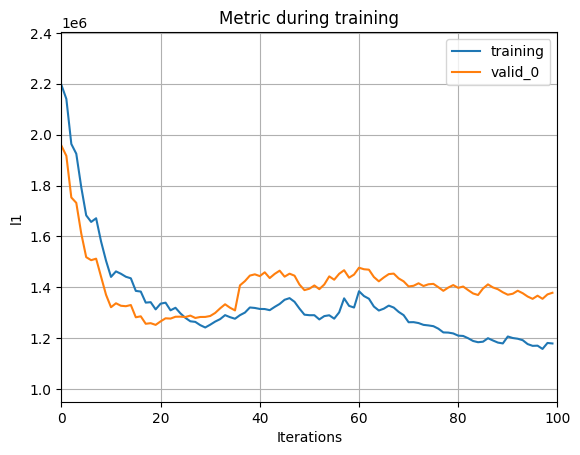

In [104]:
lgb.plot_metric(model,
                metric='l1')